In [ ]:
#@title Install third-party software

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left to download and import third-party software 

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      # Install OpenMM and pdbfixer.
      %shell rm -rf /opt/conda
      %shell wget -q -P /tmp \
        https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
          && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
          && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
      pbar.update(75)
      %shell pip install biopython ncbi-acc-download


      PATH=%env PATH
      %env PATH=/opt/conda/bin:{PATH}
      %shell conda update -qy conda \
          && conda install -qy -c bioconda \
            entrez-direct
      pbar.update(100)

except subprocess.CalledProcessError:
  print(captured)

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [ ]:
#@markdown Import libraries
import sys
import Bio
from Bio import SeqIO, SeqFeature, GenBank
from Bio.SeqRecord import SeqRecord
import os
import re
import pandas as pd
from Bio.Seq import Seq
import numpy as np


In [ ]:
#@markdown Def functions

def generate_records(genbank_path):
    index, start, end, strand, gene, product, df2_sequence, seq, GO, old_locus_tag = [],[],[],[],[],[],[],[],[],[]
    df= pd.DataFrame()
    #loading CDS
    for record in SeqIO.parse(genbank_path, "genbank"):
        for k,v in enumerate(record.features):
            if record.features[k].type =="CDS":
                index.append(k)
        for i in index:
                location = re.findall(r'\d+',repr(record.features[i].location))
                if len(location)==3: 
                    start.append(location[0])
                    end.append(location[1])
                    strand.append(record.features[i].strand)
                elif len(location)==6 and record.features[i].strand==1:
                    start.append(location[0])
                    end.append(location[4])
                    strand.append(record.features[i].strand)
                elif len(location)==6 and record.features[i].strand==-1:
                    start.append(location[3])
                    end.append(location[1])
                    strand.append(record.features[i].strand)
                try:
                    gene.append(record.features[i].qualifiers["locus_tag"][0])
                except KeyError:
                    gene.append(record.features[i].qualifiers["gene"][0])
                try: 
                    product.append(record.features[i].qualifiers["product"][0])
                except KeyError:
                    product.append(record.features[i].qualifiers["note"][0])
                try: 
                    GO.append(record.features[i].qualifiers["GO_process"][0])
                except KeyError:
                    GO.append("Not available")
                if "old_locus_tag" in record.features[i].qualifiers:
                    old_locus_tag.append(record.features[i].qualifiers["old_locus_tag"][0])
                else:
                    old_locus_tag.append("Not available")
    
        df["gene"], df["old_locus_tag"], df["product"], df["start"], df["end"], df["strand"], df["GO_process"] =gene, old_locus_tag, product, start, end, strand, GO
    return df


def extract_sequences(df, expected_len): 
    seq, temp_str = [], []
    l=len(record)
      #Extracting intergenic DNA sequences 
          #Assigning based on strand 
    for i,v in enumerate(df.gene):
        s =  int(df.start[i])
        e = int(df.end[i])
        if df["strand"][i]==1:
            
            if s-expected_len >=0:
                temp_str=str(record[s-expected_len:s].seq)
                seq.append(temp_str)
            else:
                temp_str=str(record[l-expected_len-2:l].seq) + str(record[0:s].seq)
                seq.append(temp_str)
        else:
            
            if e+expected_len <=l:
                temp_str=str(record[e:e+expected_len].seq.reverse_complement())
                seq.append(temp_str)
            else:
                temp_str=str(record[e:l].seq.reverse_complement()+ record[0:expected_len-len(record[e:l].seq)].seq.reverse_complement())
                seq.append(temp_str)
    return seq

In [ ]:
#@title 1.3 Download genbank: 
query = input("Enter NCBI accession number to download genbank file:")
output_name = input("enter output name: ")
!ncbi-acc-download {query} --out {output_name}

In [ ]:
#parsing
def parse_product(ID):
  try: 
      x=ID
      parsing = ok1.loc[ok1["gene"].str.contains(x, case=False)]["product"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y
def sub(pattern,string):
#    pattern = "gnl\|extdb\|"
    seq = re.sub(pattern,"",string)
    return seq

In [ ]:
blast2go = pd.read_csv("blast2go_table.txt", header=0,sep="\t")
blast2go

,Unnamed: 0,Tags,SeqName,Description,Length,#Hits,e-Value,sim mean,#GO,GO IDs,GO Names,Enzyme Codes,Enzyme Names,InterPro IDs,InterPro GO IDs,InterPro GO Names
0,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_001889,S9 family peptidase,707,20.0,0.000000e+00,87.96,2.0,P:GO:0006508; F:GO:0004252,P:proteolysis; F:serine-type endopeptidase act...,EC:3.4.21,Acting on peptide bonds (peptidases),NaN,NaN,NaN
1,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_001891,PLP-dependent transferase,432,20.0,0.000000e+00,94.52,7.0,P:GO:0019344; P:GO:0019346; P:GO:0071266; F:GO...,P:cysteine biosynthetic process; P:transsulfur...,EC:2.6.1; EC:2.5.1.49; EC:2.5.1.47,Transferring nitrogenous groups; O-acetylhomos...,NaN,NaN,NaN
2,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_001892,bifunctional adenosylcobinamide kinase/adenosy...,171,20.0,1.552410e-101,84.73,7.0,P:GO:0009236; P:GO:0016310; F:GO:0005524; F:GO...,P:cobalamin biosynthetic process; P:phosphoryl...,EC:2.7.7.62; EC:2.7.1.156,Adenosylcobinamide-phosphate guanylyltransfera...,NaN,NaN,NaN
3,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_001893,cobalt-precorrin-5B (C(1))-methyltransferase,370,20.0,0.000000e+00,88.54,4.0,P:GO:0009236; P:GO:0032259; P:GO:0046140; F:GO...,P:cobalamin biosynthetic process; P:methylatio...,EC:2.1.1,Transferring one-carbon groups,NaN,NaN,NaN
4,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_001894,YbhB/YbcL family Raf kinase inhibitor-like pro...,185,20.0,1.704400e-104,90.67,2.0,P:GO:0016310; F:GO:0016301,P:phosphorylation; F:kinase activity,EC:2.7,Transferring phosphorus-containing groups,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,True,[BLASTED],gnl|extdb|pgaptmp_004042,YaiI/YqxD family protein,157,20.0,5.506790e-111,90.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3889,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_004053,chromate resistance protein,275,20.0,0.000000e+00,89.50,1.0,F:GO:0016740,F:transferase activity,EC:2,Transferases,NaN,NaN,NaN
3890,True,"[BLASTED, MAPPED, ANNOTATED]",gnl|extdb|pgaptmp_004075,NAD-dependent succinate-semialdehyde dehydroge...,439,20.0,0.000000e+00,81.51,1.0,F:GO:0004030,F:aldehyde dehydrogenase [NAD(P)+] activity,EC:1.2.1.5,Aldehyde dehydrogenase (NAD(P)(+)),NaN,NaN,NaN
3891,True,[BLASTED],gnl|extdb|pgaptmp_004029,hypothetical protein,282,2.0,1.704630e-176,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
deseq=pd.read_csv("2_samples_condition_treated_results_ressig.csv", header=0)
deseq.rename(columns={"Unnamed: 0":"ID"}, inplace=True)
deseq


,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,gene-pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00
1,gene-pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296
2,gene-pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264
3,gene-pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260
4,gene-pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257
...,...,...,...,...,...,...,...
2805,gene-pgaptmp_000420,2197.677738,-0.467945,0.255847,-1.829002,6.739925e-02,9.821367e-02
2806,gene-pgaptmp_003582,1436.116961,-0.431071,0.235709,-1.828828,6.742545e-02,9.821367e-02
2807,gene-pgaptmp_000116,3404.795779,-0.354644,0.193921,-1.828805,6.742885e-02,9.821367e-02
2808,gene-pgaptmp_000928,555.607634,-0.461918,0.253317,-1.823481,6.823055e-02,9.934601e-02


In [ ]:
deseq["ID"]= deseq["ID"].apply(lambda x:sub("rna-",x))
deseq["ID"]= deseq["ID"].apply(lambda x:sub("gene-",x))
deseq

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00
1,pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260
4,pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257
...,...,...,...,...,...,...,...
2805,pgaptmp_000420,2197.677738,-0.467945,0.255847,-1.829002,6.739925e-02,9.821367e-02
2806,pgaptmp_003582,1436.116961,-0.431071,0.235709,-1.828828,6.742545e-02,9.821367e-02
2807,pgaptmp_000116,3404.795779,-0.354644,0.193921,-1.828805,6.742885e-02,9.821367e-02
2808,pgaptmp_000928,555.607634,-0.461918,0.253317,-1.823481,6.823055e-02,9.934601e-02


In [ ]:
ok1_chrm = generate_records("ok1-1contig1.gb")
ok1_plas= generate_records("ok1-1contig2.gb")
ok1= pd.concat([ok1_chrm,ok1_plas],axis =0, ignore_index=True).reset_index(drop=True)
ok1

/usr/local/lib/python3.7/dist-packages/Bio/GenBank/__init__.py:364: BiopythonParserWarning: Attempting to fix invalid location '3910798..1' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  BiopythonParserWarning,
/usr/local/lib/python3.7/dist-packages/Bio/GenBank/__init__.py:364: BiopythonParserWarning: Attempting to fix invalid location '353454..1251' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  BiopythonParserWarning,


,gene,old_locus_tag,product,start,end,strand,GO_process
0,pgaptmp_000002,Not available,hypothetical protein,382,2281,1,Not available
1,pgaptmp_000003,Not available,tetratricopeptide repeat protein,2897,6044,1,Not available
2,pgaptmp_000004,Not available,IS66 family transposase,6532,8068,-1,Not available
3,pgaptmp_000005,Not available,IS66 family insertion sequence element accesso...,8137,8494,-1,Not available
4,pgaptmp_000006,Not available,transposase,8709,8865,-1,Not available
...,...,...,...,...,...,...,...
4019,pgaptmp_004087,Not available,B12-binding domain-containing radical SAM protein,349475,351062,1,Not available
4020,pgaptmp_004088,Not available,cytochrome c,351341,351995,-1,Not available
4021,pgaptmp_004089,Not available,cytochrome c,352038,352653,-1,Not available
4022,pgaptmp_004090,Not available,cytochrome c,352685,353321,-1,Not available


In [ ]:
deseq["product"]= deseq["ID"].apply(lambda x: parse_product(x))
deseq

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...
1,pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296,hypothetical protein
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260,2-oxo acid dehydrogenase subunit E2
4,pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257,hypothetical protein
...,...,...,...,...,...,...,...,...
2805,pgaptmp_000420,2197.677738,-0.467945,0.255847,-1.829002,6.739925e-02,9.821367e-02,EAL domain-containing protein
2806,pgaptmp_003582,1436.116961,-0.431071,0.235709,-1.828828,6.742545e-02,9.821367e-02,efflux RND transporter periplasmic adaptor sub...
2807,pgaptmp_000116,3404.795779,-0.354644,0.193921,-1.828805,6.742885e-02,9.821367e-02,quinone oxidoreductase
2808,pgaptmp_000928,555.607634,-0.461918,0.253317,-1.823481,6.823055e-02,9.934601e-02,NUDIX hydrolase


In [ ]:
blast2go["SeqName"]=blast2go["SeqName"].apply(lambda x: sub("gnl\|extdb\|",x))
blast2go

,Unnamed: 0,Tags,SeqName,Description,Length,#Hits,e-Value,sim mean,#GO,GO IDs,GO Names,Enzyme Codes,Enzyme Names,InterPro IDs,InterPro GO IDs,InterPro GO Names
0,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_001889,S9 family peptidase,707,20.0,0.000000e+00,87.96,2.0,P:GO:0006508; F:GO:0004252,P:proteolysis; F:serine-type endopeptidase act...,EC:3.4.21,Acting on peptide bonds (peptidases),NaN,NaN,NaN
1,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_001891,PLP-dependent transferase,432,20.0,0.000000e+00,94.52,7.0,P:GO:0019344; P:GO:0019346; P:GO:0071266; F:GO...,P:cysteine biosynthetic process; P:transsulfur...,EC:2.6.1; EC:2.5.1.49; EC:2.5.1.47,Transferring nitrogenous groups; O-acetylhomos...,NaN,NaN,NaN
2,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_001892,bifunctional adenosylcobinamide kinase/adenosy...,171,20.0,1.552410e-101,84.73,7.0,P:GO:0009236; P:GO:0016310; F:GO:0005524; F:GO...,P:cobalamin biosynthetic process; P:phosphoryl...,EC:2.7.7.62; EC:2.7.1.156,Adenosylcobinamide-phosphate guanylyltransfera...,NaN,NaN,NaN
3,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_001893,cobalt-precorrin-5B (C(1))-methyltransferase,370,20.0,0.000000e+00,88.54,4.0,P:GO:0009236; P:GO:0032259; P:GO:0046140; F:GO...,P:cobalamin biosynthetic process; P:methylatio...,EC:2.1.1,Transferring one-carbon groups,NaN,NaN,NaN
4,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_001894,YbhB/YbcL family Raf kinase inhibitor-like pro...,185,20.0,1.704400e-104,90.67,2.0,P:GO:0016310; F:GO:0016301,P:phosphorylation; F:kinase activity,EC:2.7,Transferring phosphorus-containing groups,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,True,[BLASTED],pgaptmp_004042,YaiI/YqxD family protein,157,20.0,5.506790e-111,90.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3889,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_004053,chromate resistance protein,275,20.0,0.000000e+00,89.50,1.0,F:GO:0016740,F:transferase activity,EC:2,Transferases,NaN,NaN,NaN
3890,True,"[BLASTED, MAPPED, ANNOTATED]",pgaptmp_004075,NAD-dependent succinate-semialdehyde dehydroge...,439,20.0,0.000000e+00,81.51,1.0,F:GO:0004030,F:aldehyde dehydrogenase [NAD(P)+] activity,EC:1.2.1.5,Aldehyde dehydrogenase (NAD(P)(+)),NaN,NaN,NaN
3891,True,[BLASTED],pgaptmp_004029,hypothetical protein,282,2.0,1.704630e-176,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#parsing go_table
def parse_GO(ID,blast2go):
  try: 
      x=ID
      parsing = blast2go.loc[blast2go["SeqName"].str.contains(x, case=False)]["GO IDs"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y
def parse_GO_names(ID,blast2go):
  try: 
      x=ID
      parsing = blast2go.loc[blast2go["SeqName"].str.contains(x, case=False)]["GO Names"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y
def parse_description(ID,blast2go):
  try: 
      x=ID
      parsing = blast2go.loc[blast2go["SeqName"].str.contains(x, case=False)]["Description"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y

def parse_EC(ID,blast2go):
  try: 
      x=ID
      parsing = blast2go.loc[blast2go["SeqName"].str.contains(x, case=False)]["Enzyme Codes"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y

def parse_EC_names(ID,blast2go):
  try: 
      x=ID
      parsing = blast2go.loc[blast2go["SeqName"].str.contains(x, case=False)]["Enzyme Names"].squeeze()
      y = parsing
  except KeyError:
      y = "Not available"
  return y

In [ ]:
deseq["Description"]= deseq["ID"].apply(lambda x: parse_description(x,blast2go))
deseq["GO"]= deseq["ID"].apply(lambda x: parse_GO(x,blast2go))
deseq["GO_names"]= deseq["ID"].apply(lambda x: parse_GO_names(x,blast2go))
deseq["EC"]= deseq["ID"].apply(lambda x: parse_EC(x,blast2go))
deseq["EC_names"]= deseq["ID"].apply(lambda x: parse_EC_names(x,blast2go))
deseq

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,P:GO:0006096; F:GO:0004739,P:glycolytic process; F:pyruvate dehydrogenase...,EC:1.2.4.1,Pyruvate dehydrogenase (acetyl-transferring)
1,pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296,hypothetical protein,general stress protein,C:GO:0016021,C:integral component of membrane,NaN,NaN
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,P:GO:0009072; F:GO:0003868; F:GO:0046872,P:aromatic amino acid family metabolic process...,EC:1.13.11.27,4-hydroxyphenylpyruvate dioxygenase
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260,2-oxo acid dehydrogenase subunit E2,2-oxo acid dehydrogenase subunit E2,F:GO:0016746; C:GO:0005737,F:acyltransferase activity; C:cytoplasm,EC:2.3,Acyltransferases
4,pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257,hypothetical protein,hypothetical protein pgaptmp_003871 [Methylocy...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,pgaptmp_000420,2197.677738,-0.467945,0.255847,-1.829002,6.739925e-02,9.821367e-02,EAL domain-containing protein,EAL domain-containing protein,C:GO:0016020,C:membrane,NaN,NaN
2806,pgaptmp_003582,1436.116961,-0.431071,0.235709,-1.828828,6.742545e-02,9.821367e-02,efflux RND transporter periplasmic adaptor sub...,efflux RND transporter periplasmic adaptor sub...,P:GO:0055085; F:GO:0022857; C:GO:0016020,P:transmembrane transport; F:transmembrane tra...,EC:7,Translocases
2807,pgaptmp_000116,3404.795779,-0.354644,0.193921,-1.828805,6.742885e-02,9.821367e-02,quinone oxidoreductase,quinone oxidoreductase,F:GO:0008270; F:GO:0016616,"F:zinc ion binding; F:oxidoreductase activity,...",EC:1.1.1,Acting on the CH-OH group of donors
2808,pgaptmp_000928,555.607634,-0.461918,0.253317,-1.823481,6.823055e-02,9.934601e-02,NUDIX hydrolase,NUDIX hydrolase,F:GO:0016787,F:hydrolase activity,EC:3,Hydrolases


In [ ]:
deseq.to_csv("deseq_blas2go_h2s_ch4.csv", index=False)

In [ ]:
deseq=deseq[deseq["padj"]<0.05]

In [ ]:
deseq

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,P:GO:0006096; F:GO:0004739,P:glycolytic process; F:pyruvate dehydrogenase...,EC:1.2.4.1,Pyruvate dehydrogenase (acetyl-transferring)
1,pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296,hypothetical protein,general stress protein,C:GO:0016021,C:integral component of membrane,NaN,NaN
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,P:GO:0009072; F:GO:0003868; F:GO:0046872,P:aromatic amino acid family metabolic process...,EC:1.13.11.27,4-hydroxyphenylpyruvate dioxygenase
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260,2-oxo acid dehydrogenase subunit E2,2-oxo acid dehydrogenase subunit E2,F:GO:0016746; C:GO:0005737,F:acyltransferase activity; C:cytoplasm,EC:2.3,Acyltransferases
4,pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257,hypothetical protein,hypothetical protein pgaptmp_003871 [Methylocy...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,pgaptmp_003691,1218.013272,-0.466240,0.215746,-2.161059,3.069080e-02,4.852160e-02,GyrI-like domain-containing protein,GyrI-like domain-containing protein,C:GO:0016021,C:integral component of membrane,NaN,NaN
2587,pgaptmp_001727,401.555065,-0.658149,0.304719,-2.159857,3.078371e-02,4.864968e-02,"Series([], Name: product, dtype: object)","Series([], Name: Description, dtype: object)","Series([], Name: GO IDs, dtype: object)","Series([], Name: GO Names, dtype: object)","Series([], Name: Enzyme Codes, dtype: object)","Series([], Name: Enzyme Names, dtype: object)"
2588,pgaptmp_003731,498.640875,0.571933,0.265223,2.156418,3.105104e-02,4.905320e-02,class II aldolase/adducin family protein,class II aldolase/adducin family protein,NaN,NaN,NaN,NaN
2589,pgaptmp_000801,1210.953773,0.483580,0.224297,2.155976,3.108556e-02,4.908878e-02,methyl-accepting chemotaxis protein,methyl-accepting chemotaxis protein,P:GO:0006935; P:GO:0007165; F:GO:0004888; C:GO...,P:chemotaxis; P:signal transduction; F:transme...,NaN,NaN


In [ ]:
#deseq.to_csv("EdgeR_blas2go_h2s_ch4_p_005.csv", index=False)

In [ ]:
up = deseq[deseq["log2FoldChange"]>1]
down = deseq[deseq["log2FoldChange"]<-1]

In [ ]:
up

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,P:GO:0006096; F:GO:0004739,P:glycolytic process; F:pyruvate dehydrogenase...,EC:1.2.4.1,Pyruvate dehydrogenase (acetyl-transferring)
1,pgaptmp_000433,17703.846643,7.391698,0.199757,37.003426,1.008664e-299,2.062718e-296,hypothetical protein,general stress protein,C:GO:0016021,C:integral component of membrane,NaN,NaN
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,P:GO:0009072; F:GO:0003868; F:GO:0046872,P:aromatic amino acid family metabolic process...,EC:1.13.11.27,4-hydroxyphenylpyruvate dioxygenase
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260,2-oxo acid dehydrogenase subunit E2,2-oxo acid dehydrogenase subunit E2,F:GO:0016746; C:GO:0005737,F:acyltransferase activity; C:cytoplasm,EC:2.3,Acyltransferases
4,pgaptmp_003871,18886.005702,7.438384,0.216072,34.425539,1.046270e-259,8.558485e-257,hypothetical protein,hypothetical protein pgaptmp_003871 [Methylocy...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,pgaptmp_001641,206.660337,1.039715,0.437283,2.377673,1.742228e-02,2.895454e-02,type IV secretory system conjugative DNA trans...,type IV secretory system conjugative DNA trans...,C:GO:0016020,C:membrane,NaN,NaN
2471,pgaptmp_002986,857323.028768,3.353812,1.416007,2.368499,1.786041e-02,2.954019e-02,"Series([], Name: product, dtype: object)","Series([], Name: Description, dtype: object)","Series([], Name: GO IDs, dtype: object)","Series([], Name: GO Names, dtype: object)","Series([], Name: Enzyme Codes, dtype: object)","Series([], Name: Enzyme Names, dtype: object)"
2472,pgaptmp_002099,201.037693,1.052743,0.444481,2.368480,1.786134e-02,2.954019e-02,hypothetical protein,O-antigen ligase family protein,F:GO:0016874; C:GO:0016020; C:GO:0016021,F:ligase activity; C:membrane; C:integral comp...,NaN,NaN
2482,pgaptmp_000002,123.083035,1.008738,0.429316,2.349638,1.879166e-02,3.095364e-02,hypothetical protein,cytochrome C,NaN,NaN,NaN,NaN


In [ ]:
down

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
129,pgaptmp_002272,3533.739247,-4.317100,0.209556,-20.601199,2.677318e-94,8.423255e-93,30S ribosomal protein S12,30S ribosomal protein S12,P:GO:0006412; F:GO:0000049; F:GO:0003735; F:GO...,P:translation; F:tRNA binding; F:structural co...,NaN,NaN
135,pgaptmp_002539,6821.641917,-4.458077,0.220687,-20.200920,9.608943e-91,2.889748e-89,SRPBCC family protein,SRPBCC family protein,NaN,NaN,NaN,NaN
145,pgaptmp_001672,88588.434116,-3.874603,0.202997,-19.087010,3.237770e-81,9.070190e-80,porin,outer membrane beta-barrel protein,NaN,NaN,NaN,NaN
146,pgaptmp_000451,13379.787476,-5.004719,0.262610,-19.057630,5.678997e-81,1.580075e-79,FAD-dependent monooxygenase,FAD-dependent monooxygenase,F:GO:0004497; F:GO:0071949; C:GO:0016021,F:monooxygenase activity; F:FAD binding; C:int...,EC:1,Oxidoreductases
147,pgaptmp_002707,264508.009137,-3.479187,0.182819,-19.030734,9.491347e-81,2.622947e-79,outer membrane beta-barrel protein,porin family protein,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,pgaptmp_003005,275.318718,-1.032866,0.408025,-2.531381,1.136144e-02,1.955737e-02,hypothetical protein,hypothetical protein pgaptmp_003005 [Methylocy...,NaN,NaN,NaN,NaN
2384,pgaptmp_000021,122.402123,-1.197137,0.477760,-2.505727,1.221998e-02,2.095585e-02,DUF2840 domain-containing protein,"Series([], Name: Description, dtype: object)","Series([], Name: GO IDs, dtype: object)","Series([], Name: GO Names, dtype: object)","Series([], Name: Enzyme Codes, dtype: object)","Series([], Name: Enzyme Names, dtype: object)"
2385,pgaptmp_000880,128.985868,-1.031304,0.412069,-2.502746,1.232341e-02,2.112437e-02,uroporphyrinogen-III synthase,uroporphyrinogen-III synthase,P:GO:0033014; F:GO:0004852,P:tetrapyrrole biosynthetic process; F:uroporp...,EC:4.2.1.75,Uroporphyrinogen-III synthase
2432,pgaptmp_000056,139.278146,-1.004802,0.415707,-2.417090,1.564515e-02,2.630031e-02,ribonuclease HI,ribonuclease HI,P:GO:0006401; P:GO:0090502; F:GO:0000287; F:GO...,P:RNA catabolic process; P:RNA phosphodiester ...,EC:3.1.30; EC:3.1.26.4,Acting on ester bonds; Ribonuclease H


In [ ]:
GO_group = deseq.GO_names.tolist()
GO_split=[]
for i in GO_group:
  GO_split.append(str(i).split('; '))
flat_list = [item for sublist in GO_split for item in sublist]
GO_P_group= pd.DataFrame()
GO_P_group["Pathway Group"] =flat_list
GO_P_group=GO_P_group.loc[GO_P_group["Pathway Group"].str.contains("P:", case=False)]
GO_P_group

,Pathway Group
0,P:glycolytic process
3,P:aromatic amino acid family metabolic process
11,P:regulation of translation
18,P:organonitrogen compound catabolic process
24,P:electron transport chain
...,...
6205,P:protoporphyrinogen IX biosynthetic process
6209,P:protein methylation
6214,P:chemotaxis
6215,P:signal transduction


In [ ]:
GO_P_group["Pathway Group"]=GO_P_group["Pathway Group"].apply(lambda x: sub("\'", x))
GO_P_group["Pathway Group"]=GO_P_group["Pathway Group"].apply(lambda x: sub("\[", x))
GO_P_group["Pathway Group"]=GO_P_group["Pathway Group"].apply(lambda x: sub("\]", x))
GO_P_group["Pathway Group"]=GO_P_group["Pathway Group"].apply(lambda x: sub("P:", x))
GO_P_group["Pathway Group"]=GO_P_group["Pathway Group"].apply(lambda x: x[0].capitalize()+x[1:])
GO_P_group

,Pathway Group
0,Glycolytic process
3,Aromatic amino acid family metabolic process
11,Regulation of translation
18,Organonitrogen compound catabolic process
24,Electron transport chain
...,...
6205,Protoporphyrinogen IX biosynthetic process
6209,Protein methylation
6214,Chemotaxis
6215,Signal transduction


In [ ]:
unique_P_group = GO_P_group["Pathway Group"].unique()
unique_P_group = list(unique_P_group)
len(unique_P_group)

453

In [ ]:
unique_P_group

['Glycolytic process',
 'Aromatic amino acid family metabolic process',
 'Regulation of translation',
 'Organonitrogen compound catabolic process',
 'Electron transport chain',
 'Proton transmembrane transport',
 'Aerobic electron transport chain',
 'Lipid biosynthetic process',
 'Peptidyl-histidine phosphorylation',
 'Cellular amino acid metabolic process',
 'Positive regulation of DNA-templated transcription',
 'Aerobic respiration',
 'Cellular oxidant detoxification',
 'L-phenylalanine catabolic process',
 'Tyrosine catabolic process',
 'Oxidative phosphorylation',
 'Electron transport coupled proton transport',
 'DNA integration',
 'Valine catabolic process',
 'Regulation of DNA-templated transcription initiation',
 'Lipid metabolic process',
 'Response to copper ion',
 'Transmembrane transport',
 'Molybdate ion transport',
 'Regulation of DNA-templated transcription',
 'Carbohydrate metabolic process',
 'Peptide metabolic process',
 'Protein processing',
 'Methylation',
 'Transsul

In [ ]:
up_counts=[]
for i in unique_P_group:
  l= len(up.loc[up["GO_names"].str.contains(i, case=False).fillna(False)])
  up_counts.append(l)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
upregulated_pathway= pd.DataFrame()
upregulated_pathway["pathways"] = unique_P_group
upregulated_pathway["gene_counts"] = up_counts
upregulated_pathway

,pathways,gene_counts
0,Glycolytic process,3
1,Aromatic amino acid family metabolic process,1
2,Regulation of translation,1
3,Organonitrogen compound catabolic process,1
4,Electron transport chain,24
...,...,...
448,Cobalt ion transport,0
449,Organic acid metabolic process,0
450,Acetyl-CoA biosynthetic process,0
451,DTDP biosynthetic process,0


In [ ]:
upregulated_pathway=upregulated_pathway[upregulated_pathway["gene_counts"] >0]
upregulated_pathway=upregulated_pathway.sort_values(by='gene_counts', ascending=False)
upregulated_pathway2=upregulated_pathway.head(20)
upregulated_pathway2["pathways"]=upregulated_pathway2["pathways"].apply(lambda x: sub("P:",x))
upregulated_pathway2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,pathways,gene_counts
204,Transport,67
148,Biosynthetic process,54
118,Metabolic process,48
22,Transmembrane transport,43
24,Regulation of DNA-templated transcription,30
337,DNA-templated transcription,30
31,Phosphorylation,24
4,Electron transport chain,24
38,Proteolysis,20
41,Signal transduction,14


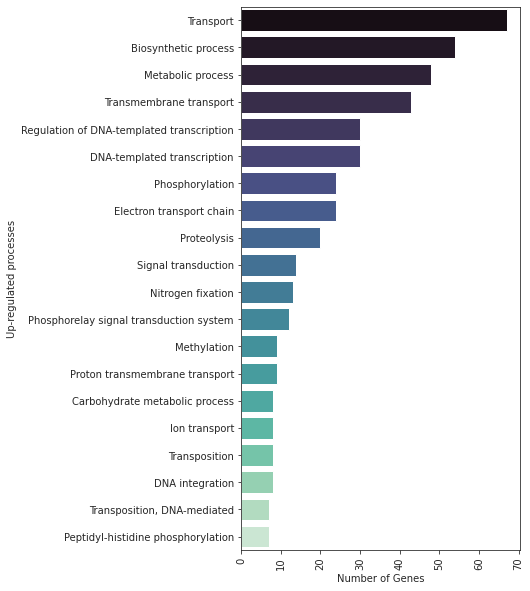

In [ ]:
plt.rcParams.update({'font.size': 10})
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5,10))
ax =sns.barplot(y="pathways", x="gene_counts", data=upregulated_pathway2,palette="mako")
plt.xlabel('Number of Genes')
plt.ylabel('Up-regulated processes')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()


In [ ]:
count_down=[]
for i in unique_P_group:
  l= len(down.loc[down["GO_names"].str.contains(i, case=False).fillna(False)])
  count_down.append(l)
down_regulated_pathway= pd.DataFrame()
down_regulated_pathway["pathways"] = unique_P_group
down_regulated_pathway["gene_counts"] = count_down


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
down_regulated_pathway=down_regulated_pathway[down_regulated_pathway["gene_counts"] >0]
down_regulated_pathway=down_regulated_pathway.sort_values(by='gene_counts', ascending=False)
down_regulated_pathway2=down_regulated_pathway.head(20)
down_regulated_pathway2["pathways"]=down_regulated_pathway2["pathways"].apply(lambda x: sub("P:",x))
down_regulated_pathway2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,pathways,gene_counts
204,Transport,97
148,Biosynthetic process,96
33,Translation,56
22,Transmembrane transport,50
118,Metabolic process,36
4,Electron transport chain,24
337,DNA-templated transcription,18
28,Methylation,18
24,Regulation of DNA-templated transcription,17
31,Phosphorylation,15


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

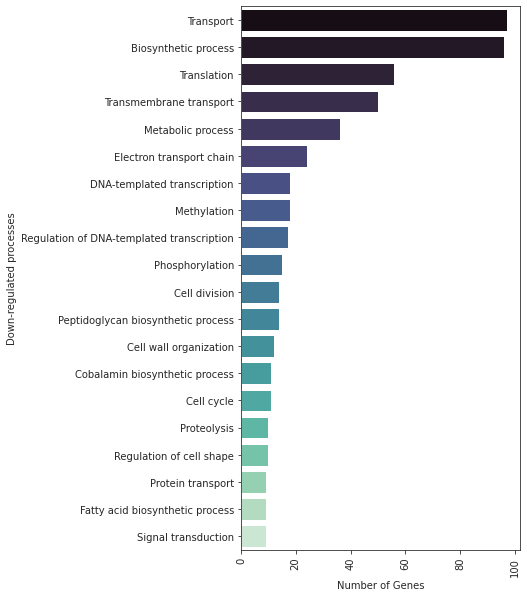

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5,10))
ax =sns.barplot(y="pathways", x="gene_counts", data=down_regulated_pathway2,palette="mako")
plt.xlabel('Number of Genes')
plt.ylabel('Down-regulated processes')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()


In [ ]:
deseq=deseq.sort_values(by='log2FoldChange', ascending=False)
deseq

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
8,pgaptmp_000415,32939.770532,8.167689,0.244413,33.417502,7.635981e-245,3.470129e-242,SH3 domain-containing protein,SH3 domain-containing protein,NaN,NaN,NaN,NaN
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,P:GO:0006096; F:GO:0004739,P:glycolytic process; F:pyruvate dehydrogenase...,EC:1.2.4.1,Pyruvate dehydrogenase (acetyl-transferring)
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,P:GO:0009072; F:GO:0003868; F:GO:0046872,P:aromatic amino acid family metabolic process...,EC:1.13.11.27,4-hydroxyphenylpyruvate dioxygenase
49,pgaptmp_000393,3995.563596,7.671612,0.284754,26.941207,7.231678e-160,5.915513e-158,hypothetical protein,hypothetical protein,NaN,NaN,NaN,NaN
13,pgaptmp_002085,13174.635444,7.514709,0.233979,32.117015,2.551709e-226,7.454637e-224,alpha-ketoacid dehydrogenase subunit beta,alpha-ketoacid dehydrogenase subunit beta,F:GO:0003824,F:catalytic activity,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,pgaptmp_000451,13379.787476,-5.004719,0.262610,-19.057630,5.678997e-81,1.580075e-79,FAD-dependent monooxygenase,FAD-dependent monooxygenase,F:GO:0004497; F:GO:0071949; C:GO:0016021,F:monooxygenase activity; F:FAD binding; C:int...,EC:1,Oxidoreductases
196,pgaptmp_000450,13952.915697,-5.531037,0.331654,-16.677115,1.922830e-62,3.992069e-61,MATE family efflux transporter,multi antimicrobial extrusion protein MatE,C:GO:0016020,C:membrane,NaN,NaN
769,pgaptmp_003177,121948.220755,-5.577499,0.737330,-7.564458,3.894858e-14,2.068827e-13,TonB-dependent receptor,TonB-dependent receptor,C:GO:0009279,C:cell outer membrane,NaN,NaN
888,pgaptmp_000449,35173.902699,-6.228963,0.895648,-6.954698,3.533185e-12,1.625503e-11,methanobactin biosynthesis cassette protein MbnC,methanobactin biosynthesis cassette protein MbnC,NaN,NaN,NaN,NaN


In [ ]:
deseq2 = deseq[ deseq["product"].str.contains( "hypothetical protein" )==False ]
deseq2

,ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,Description,GO,GO_names,EC,EC_names
8,pgaptmp_000415,32939.770532,8.167689,0.244413,33.417502,7.635981e-245,3.470129e-242,SH3 domain-containing protein,SH3 domain-containing protein,NaN,NaN,NaN,NaN
0,pgaptmp_002084,18014.750113,7.991713,0.212418,37.622604,0.000000e+00,0.000000e+00,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,P:GO:0006096; F:GO:0004739,P:glycolytic process; F:pyruvate dehydrogenase...,EC:1.2.4.1,Pyruvate dehydrogenase (acetyl-transferring)
2,pgaptmp_002073,7997.187426,7.763299,0.222107,34.952953,1.167831e-267,1.592143e-264,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,P:GO:0009072; F:GO:0003868; F:GO:0046872,P:aromatic amino acid family metabolic process...,EC:1.13.11.27,4-hydroxyphenylpyruvate dioxygenase
13,pgaptmp_002085,13174.635444,7.514709,0.233979,32.117015,2.551709e-226,7.454637e-224,alpha-ketoacid dehydrogenase subunit beta,alpha-ketoacid dehydrogenase subunit beta,F:GO:0003824,F:catalytic activity,NaN,NaN
3,pgaptmp_002086,21229.200359,7.494907,0.216129,34.677891,1.697410e-263,1.735602e-260,2-oxo acid dehydrogenase subunit E2,2-oxo acid dehydrogenase subunit E2,F:GO:0016746; C:GO:0005737,F:acyltransferase activity; C:cytoplasm,EC:2.3,Acyltransferases
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,pgaptmp_000451,13379.787476,-5.004719,0.262610,-19.057630,5.678997e-81,1.580075e-79,FAD-dependent monooxygenase,FAD-dependent monooxygenase,F:GO:0004497; F:GO:0071949; C:GO:0016021,F:monooxygenase activity; F:FAD binding; C:int...,EC:1,Oxidoreductases
196,pgaptmp_000450,13952.915697,-5.531037,0.331654,-16.677115,1.922830e-62,3.992069e-61,MATE family efflux transporter,multi antimicrobial extrusion protein MatE,C:GO:0016020,C:membrane,NaN,NaN
769,pgaptmp_003177,121948.220755,-5.577499,0.737330,-7.564458,3.894858e-14,2.068827e-13,TonB-dependent receptor,TonB-dependent receptor,C:GO:0009279,C:cell outer membrane,NaN,NaN
888,pgaptmp_000449,35173.902699,-6.228963,0.895648,-6.954698,3.533185e-12,1.625503e-11,methanobactin biosynthesis cassette protein MbnC,methanobactin biosynthesis cassette protein MbnC,NaN,NaN,NaN,NaN


In [ ]:
df2 = deseq2.head(20)
df3 = deseq2.tail(20)

In [ ]:
df4=pd.concat([df2,df3], axis=0, ignore_index=True).reset_index(drop=True)
df4
new_draw= pd.DataFrame()
new_draw["product"]=df4["product"].astype(str)
new_draw["Description"]=df4["Description"].astype(str)
new_draw["log2FoldChange"]=df4["log2FoldChange"].astype(float)

In [ ]:
new_draw

,product,Description,log2FoldChange
0,SH3 domain-containing protein,SH3 domain-containing protein,8.167689
1,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,7.991713
2,4-hydroxyphenylpyruvate dioxygenase,4-hydroxyphenylpyruvate dioxygenase,7.763299
3,alpha-ketoacid dehydrogenase subunit beta,alpha-ketoacid dehydrogenase subunit beta,7.514709
4,2-oxo acid dehydrogenase subunit E2,2-oxo acid dehydrogenase subunit E2,7.494907
5,isovaleryl-CoA dehydrogenase,isovaleryl-CoA dehydrogenase,7.036965
6,glycosyltransferase,glycosyltransferase,6.989851
7,cold shock domain-containing protein,HPF/RaiA family ribosome-associated protein,6.725228
8,c-type cytochrome,c-type cytochrome,6.620832
9,PRC-barrel domain-containing protein,PRC-barrel domain-containing protein,6.609373


In [ ]:
mask = new_draw["product"].duplicated(keep=False)
new_draw.loc[mask,"product"] += new_draw.groupby("product").cumcount().add(1).astype(str)

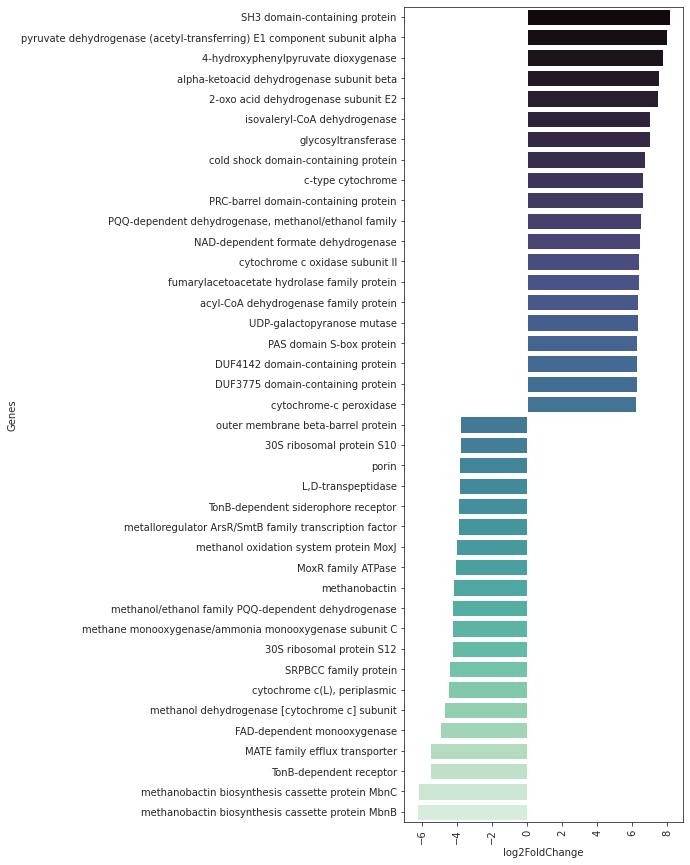

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5,15))
ax =sns.barplot(y="product", x="log2FoldChange", data=new_draw,palette="mako")
plt.xlabel('log2FoldChange')
plt.ylabel('Genes')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()


In [ ]:
GO_C_group = deseq.GO_names.tolist()
GO_C_split=[]
for i in GO_C_group:
  GO_C_split.append(str(i).split('; '))
flat_list = [item for sublist in GO_split for item in sublist]
GO_C_group= pd.DataFrame()
GO_C_group["Pathway Group"] =flat_list
GO_C_group=GO_C_group.loc[GO_C_group["Pathway Group"].str.contains("C:", case=False)]
GO_C_group["Pathway Group"]=GO_C_group["Pathway Group"].apply(lambda x: sub("C:", x))
GO_C_group["Pathway Group"]=GO_C_group["Pathway Group"].apply(lambda x: x[0].capitalize()+x[1:])
unique_C_group = GO_C_group["Pathway Group"].unique()
unique_C_group = list(unique_C_group)
len(unique_C_group)

66

In [ ]:
unique_C_group

['Integral component of membrane',
 'Cytoplasm',
 'Cytosol',
 'Plasma membrane',
 'Membrane',
 'Outer membrane-bounded periplasmic space',
 'Respirasome',
 'Periplasmic space',
 'Cytochrome complex',
 'Extracellular space',
 'Cellular_component',
 'Small ribosomal subunit',
 'Cell outer membrane',
 'Outer membrane',
 'Ribosome',
 'Proton-transporting ATP synthase complex, catalytic core F(1)',
 'Proton-transporting ATP synthase complex, coupling factor F(o)',
 'ATP-binding cassette (ABC) transporter complex',
 'Nucleoid',
 'Cell periphery',
 'Glycerol-3-phosphate dehydrogenase complex',
 'Large ribosomal subunit',
 'Vacuole',
 'Vesicle membrane',
 'Gas vesicle shell',
 'Molybdopterin synthase complex',
 'Acetyl-CoA carboxylase complex',
 'Pore complex',
 'HslUV protease complex',
 'Glycine cleavage complex',
 'Integral component of plasma membrane',
 'Cell division site',
 'Proteasome core complex',
 'Respiratory chain complex I',
 'Gas vesicle',
 'Molybdenum-iron nitrogenase complex',

In [ ]:
GO_F_group = deseq.GO_names.tolist()
GO_F_split=[]
for i in GO_F_group:
  GO_F_split.append(str(i).split('; '))
flat_list = [item for sublist in GO_split for item in sublist]
GO_F_group= pd.DataFrame()
GO_F_group["Pathway Group"] =flat_list
GO_F_group=GO_F_group.loc[GO_F_group["Pathway Group"].str.contains("F:", case=False)]
GO_F_group["Pathway Group"]=GO_F_group["Pathway Group"].apply(lambda x: sub("F:", x))
GO_F_group["Pathway Group"]=GO_F_group["Pathway Group"].apply(lambda x: x[0].capitalize()+x[1:])
unique_F_group = GO_F_group["Pathway Group"].unique()
unique_F_group = list(unique_F_group)
len(unique_F_group)

649

In [ ]:
up_C_counts=[]
for i in unique_C_group:
  l= len(up.loc[up["GO_names"].str.contains(i, case=False).fillna(False)])
  up_C_counts.append(l)

upregulated_component= pd.DataFrame()
upregulated_component["components"] = unique_C_group
upregulated_component["gene_counts"] = up_C_counts
upregulated_component=upregulated_component.sort_values(by='gene_counts', ascending=False)[:20]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

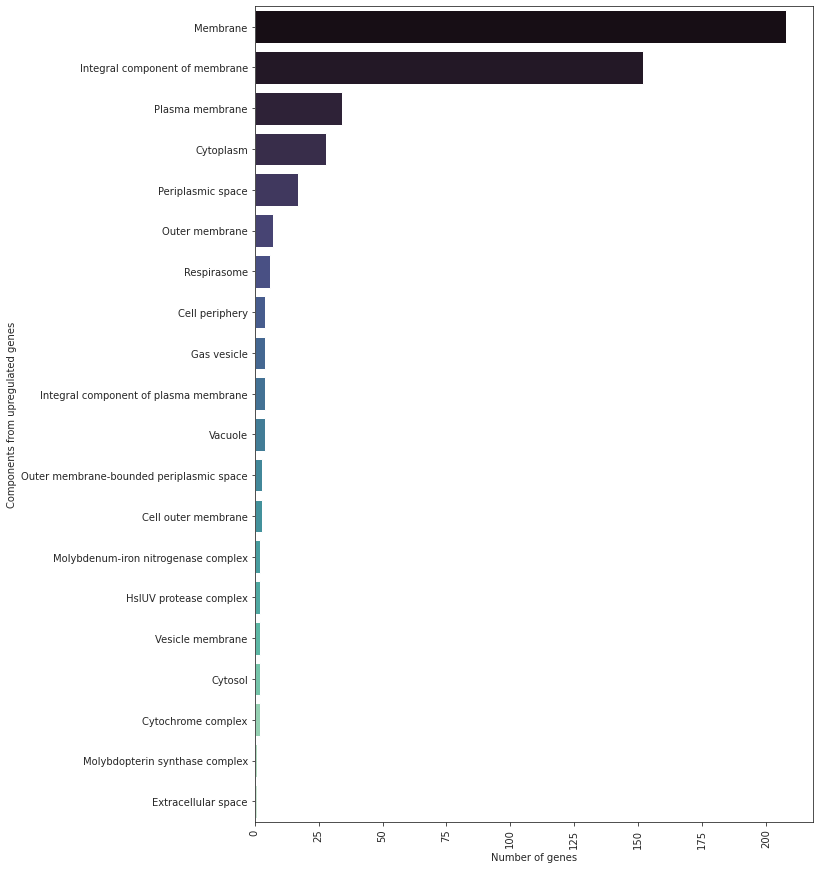

In [ ]:
plt.rcParams.update({'font.size': 10})
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10,15))
ax =sns.barplot(y="components", x="gene_counts", data=upregulated_component,palette="mako")
plt.xlabel('Number of genes')
plt.ylabel('Components from upregulated genes')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [ ]:
down_C_counts=[]
for i in unique_C_group:
  l= len(down.loc[down["GO_names"].str.contains(i, case=False).fillna(False)])
  down_C_counts.append(l)

downregulated_component= pd.DataFrame()
downregulated_component["components"] = unique_C_group
downregulated_component["gene_counts"] = down_C_counts
downregulated_component=downregulated_component.sort_values(by='gene_counts', ascending=False)[:20]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


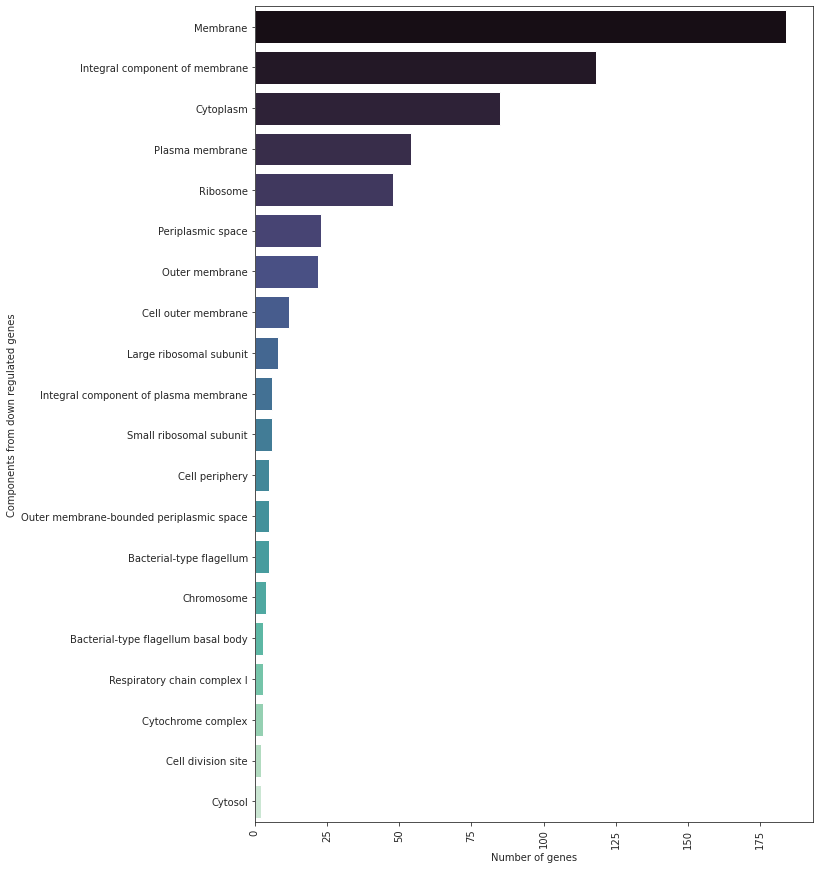

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10,15))
ax =sns.barplot(y="components", x="gene_counts", data=downregulated_component,palette="mako")
plt.xlabel('Number of genes')
plt.ylabel('Components from down regulated genes')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [ ]:
ok1

,gene,old_locus_tag,product,start,end,strand,GO_process
0,pgaptmp_000002,Not available,hypothetical protein,382,2281,1,Not available
1,pgaptmp_000003,Not available,tetratricopeptide repeat protein,2897,6044,1,Not available
2,pgaptmp_000004,Not available,IS66 family transposase,6532,8068,-1,Not available
3,pgaptmp_000005,Not available,IS66 family insertion sequence element accesso...,8137,8494,-1,Not available
4,pgaptmp_000006,Not available,transposase,8709,8865,-1,Not available
...,...,...,...,...,...,...,...
4019,pgaptmp_004087,Not available,B12-binding domain-containing radical SAM protein,349475,351062,1,Not available
4020,pgaptmp_004088,Not available,cytochrome c,351341,351995,-1,Not available
4021,pgaptmp_004089,Not available,cytochrome c,352038,352653,-1,Not available
4022,pgaptmp_004090,Not available,cytochrome c,352685,353321,-1,Not available


In [ ]:
genes = pd.read_csv("ok1_genes.csv",sep="\s", names=["contig", "gene_region",])


In [ ]:
genes

,contig,gene_region
0,G_contig1_232025_231492,contig1_232025_231492
1,G_contig1_3782523_3780832,contig1_3782523_3780832
2,G_contig1_3782538_3780835,contig1_3782538_3780835
3,G_contig1_3263703_3264707,contig1_3263703_3264707
4,G_contig1_3264730_3265701,contig1_3264730_3265701
...,...,...
710,G_contig1_3460926_3461921,contig1_3460926_3461921
711,G_contig1_2248048_2248722,contig1_2248048_2248722
712,G_contig1_3258878_3259993,contig1_3258878_3259993
713,G_contig1_70892_72028,contig1_70892_72028


In [ ]:
def gene_region(string):
  ran=[]
  loc = re.findall(r'\d+',repr(string))
  x = int(loc[1])
  y = int(loc[2])
  if x > y : 
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))
    ran.append(random.randint(y,x))

  if x < y :
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
    ran.append(random.randint(x,y))
  return ran

In [ ]:
genes["random_gene_region"]= genes["gene_region"].apply(lambda x:gene_region(x))
genes

,contig,gene_region,random_gene_region,gene_name
0,G_contig1_232025_231492,contig1_232025_231492,"[231769, 231612, 231514, 231821, 231965, 23186...",pgaptmp_000213
1,G_contig1_3782523_3780832,contig1_3782523_3780832,"[3780833, 3782115, 3781210, 3780951, 3782459, ...",pgaptmp_003617
2,G_contig1_3782538_3780835,contig1_3782538_3780835,"[3780985, 3781305, 3781436, 3782227, 3781410, ...",pgaptmp_003617
3,G_contig1_3263703_3264707,contig1_3263703_3264707,"[3264575, 3263967, 3264318, 3264214, 3264377, ...",pgaptmp_003127
4,G_contig1_3264730_3265701,contig1_3264730_3265701,"[3264941, 3265450, 3265551, 3264968, 3264885, ...",pgaptmp_003128
...,...,...,...,...
710,G_contig1_3460926_3461921,contig1_3460926_3461921,"[3460943, 3461010, 3461313, 3461784, 3461167, ...",pgaptmp_003314
711,G_contig1_2248048_2248722,contig1_2248048_2248722,"[2248358, 2248592, 2248532, 2248590, 2248172, ...",pgaptmp_002141
712,G_contig1_3258878_3259993,contig1_3258878_3259993,"[3259600, 3259494, 3259165, 3259710, 3259303, ...",pgaptmp_003123
713,G_contig1_70892_72028,contig1_70892_72028,"[71176, 71483, 71647, 71627, 71466, 71144, 712...",pgaptmp_000066


In [ ]:
def gene_finding(dataframe,query):
  val="Nan"
  query=set(query)
  for i,k in enumerate(dataframe["gene"]): 
    arr= np.arange(int(dataframe.start[i]), int(dataframe.end[i]))
    if bool(query.intersection(arr)) != False:
      val=k
    else:
      pass
  return val

In [ ]:
genes["gene_name"]= genes["random_gene_region"].apply(lambda x: gene_finding(ok1_chrm,x))
genes

,contig,gene_region,random_gene_region,gene_name
0,G_contig1_232025_231492,contig1_232025_231492,"[231769, 231612, 231514, 231821, 231965, 23186...",pgaptmp_000213
1,G_contig1_3782523_3780832,contig1_3782523_3780832,"[3780833, 3782115, 3781210, 3780951, 3782459, ...",pgaptmp_003618
2,G_contig1_3782538_3780835,contig1_3782538_3780835,"[3780985, 3781305, 3781436, 3782227, 3781410, ...",pgaptmp_003618
3,G_contig1_3263703_3264707,contig1_3263703_3264707,"[3264575, 3263967, 3264318, 3264214, 3264377, ...",pgaptmp_003127
4,G_contig1_3264730_3265701,contig1_3264730_3265701,"[3264941, 3265450, 3265551, 3264968, 3264885, ...",pgaptmp_003128
...,...,...,...,...
710,G_contig1_3460926_3461921,contig1_3460926_3461921,"[3460943, 3461010, 3461313, 3461784, 3461167, ...",pgaptmp_003314
711,G_contig1_2248048_2248722,contig1_2248048_2248722,"[2248358, 2248592, 2248532, 2248590, 2248172, ...",pgaptmp_002141
712,G_contig1_3258878_3259993,contig1_3258878_3259993,"[3259600, 3259494, 3259165, 3259710, 3259303, ...",pgaptmp_003123
713,G_contig1_70892_72028,contig1_70892_72028,"[71176, 71483, 71647, 71627, 71466, 71144, 712...",pgaptmp_000066


In [ ]:
genes2=genes[genes["gene_name"]!= "Nan"]
genes2

,contig,gene_region,random_gene_region,gene_name
0,G_contig1_232025_231492,contig1_232025_231492,"[231769, 231612, 231514, 231821, 231965, 23186...",pgaptmp_000213
1,G_contig1_3782523_3780832,contig1_3782523_3780832,"[3780833, 3782115, 3781210, 3780951, 3782459, ...",pgaptmp_003618
2,G_contig1_3782538_3780835,contig1_3782538_3780835,"[3780985, 3781305, 3781436, 3782227, 3781410, ...",pgaptmp_003618
3,G_contig1_3263703_3264707,contig1_3263703_3264707,"[3264575, 3263967, 3264318, 3264214, 3264377, ...",pgaptmp_003127
4,G_contig1_3264730_3265701,contig1_3264730_3265701,"[3264941, 3265450, 3265551, 3264968, 3264885, ...",pgaptmp_003128
...,...,...,...,...
710,G_contig1_3460926_3461921,contig1_3460926_3461921,"[3460943, 3461010, 3461313, 3461784, 3461167, ...",pgaptmp_003314
711,G_contig1_2248048_2248722,contig1_2248048_2248722,"[2248358, 2248592, 2248532, 2248590, 2248172, ...",pgaptmp_002141
712,G_contig1_3258878_3259993,contig1_3258878_3259993,"[3259600, 3259494, 3259165, 3259710, 3259303, ...",pgaptmp_003123
713,G_contig1_70892_72028,contig1_70892_72028,"[71176, 71483, 71647, 71627, 71466, 71144, 712...",pgaptmp_000066


In [ ]:
genes2=genes2.drop(columns=["random_gene_region"])


In [ ]:
genes2 = genes2.reset_index(drop = True)

In [ ]:
genes2

,contig,gene_region,gene_name
0,G_contig1_232025_231492,contig1_232025_231492,pgaptmp_000213
1,G_contig1_3782523_3780832,contig1_3782523_3780832,pgaptmp_003618
2,G_contig1_3782538_3780835,contig1_3782538_3780835,pgaptmp_003618
3,G_contig1_3263703_3264707,contig1_3263703_3264707,pgaptmp_003127
4,G_contig1_3264730_3265701,contig1_3264730_3265701,pgaptmp_003128
...,...,...,...
695,G_contig1_3460926_3461921,contig1_3460926_3461921,pgaptmp_003314
696,G_contig1_2248048_2248722,contig1_2248048_2248722,pgaptmp_002141
697,G_contig1_3258878_3259993,contig1_3258878_3259993,pgaptmp_003123
698,G_contig1_70892_72028,contig1_70892_72028,pgaptmp_000066


In [ ]:
check_list = genes2.gene_region.tolist()
replacement = genes2.gene_name.tolist()

In [ ]:
fin = open("imjc1_ok1_phb2.xml", "rt")
fout = open("imjc1_ok1_phb2_replaced_name.xml", "wt")
for line in fin:
  for check, rep in zip(check_list, replacement):
      line = line.replace(check, rep)
  fout.write(line)
fout.close()
fin.close()